In [1]:
import pandas as pd
import getpass
import functions as fn

- Leer el CSV

In [2]:
df_combined = fn.load_csv('df_combined.csv')

In [3]:
df_combined

,date,price_bitcoin,price_gold,price_sp500,change_bitcoin,change_gold,vix,interest_rate,cpi,inflation
0,2015-01-02,315,1186,2058,0.10,0.18,17.79,0.01,234.82,0.76
1,2015-01-05,275,1204,2021,3.82,1.50,19.92,0.00,234.84,0.76
2,2015-01-06,282,1219,2003,2.70,1.28,21.12,0.02,234.84,0.76
3,2015-01-07,291,1211,2026,3.21,-0.71,19.31,0.02,234.84,0.76
4,2015-01-08,283,1208,2062,-2.97,-0.18,17.01,0.02,234.85,0.76
...,...,...,...,...,...,...,...,...,...,...
2288,2024-02-05,42697,2043,4943,0.27,-0.53,13.67,5.23,307.54,3.35
2289,2024-02-06,43088,2051,4954,0.91,0.42,13.06,5.22,307.56,3.35
2290,2024-02-07,44340,2052,4995,2.91,0.01,12.83,5.22,307.58,3.35
2291,2024-02-08,45293,2048,4998,2.15,-0.19,12.79,5.22,307.60,3.35


- Conectar a la base de datos

In [4]:
password = getpass.getpass("Introduce la contraseña de MySQL: ")
engine = fn.create_db_connection(password)

- Insertar fechas y obtener id_date

In [ ]:
fn.insert_dates(df_combined, engine)
df_merged = fn.merge_dates(df_combined, engine)

- Dividir e insertar datos en las tablas 'assets' y 'economic_factors'

In [ ]:
fn.split_and_insert_data(df_merged, engine)

- Consulta 1: Crecimiento Anual de Bitcoin, Oro y S&P500 (2015-2024)

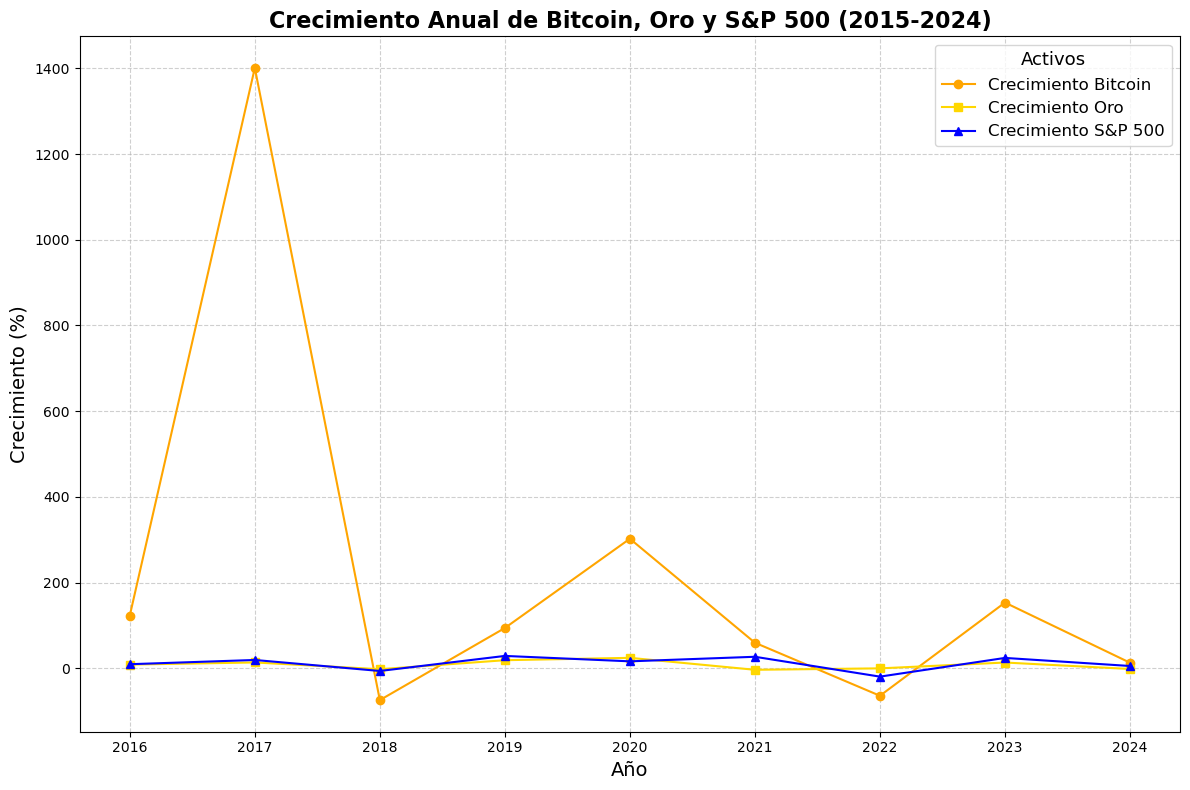

In [5]:
consulta1 = """
SELECT
    year(d.date) AS year,
    a.price_bitcoin,
    a.price_gold,
    a.price_sp500,
    ROUND( (a.price_bitcoin - LAG(a.price_bitcoin) OVER (ORDER BY year(d.date))) / LAG(a.price_bitcoin) OVER (ORDER BY year(d.date)) * 100, 2) AS bitcoin_growth,
    ROUND( (a.price_gold - LAG(a.price_gold) OVER (ORDER BY year(d.date))) / LAG(a.price_gold) OVER (ORDER BY year(d.date)) * 100, 2) AS gold_growth,
    ROUND( (a.price_sp500 - LAG(a.price_sp500) OVER (ORDER BY year(d.date))) / LAG(a.price_sp500) OVER (ORDER BY year(d.date)) * 100, 2) AS sp500_growth
FROM 
    assets a
JOIN 
    dates d ON a.id_date = d.id_date
WHERE 
    d.date IN (SELECT MAX(d2.date) FROM dates d2 GROUP BY year(d2.date))
ORDER BY 
    year(d.date);
"""
df1 = fn.execute_query(engine, consulta1)
fn.plot_growth_comparison(df1)

In [6]:
df1

,year,price_bitcoin,price_gold,price_sp500,bitcoin_growth,gold_growth,sp500_growth
0,2015,430.0,1060.0,2044.0,NaN,NaN,NaN
1,2016,959.0,1152.0,2239.0,123.02,8.68,9.54
2,2017,14393.0,1309.0,2674.0,1400.83,13.63,19.43
3,2018,3709.0,1281.0,2507.0,-74.23,-2.14,-6.25
4,2019,7196.0,1523.0,3231.0,94.01,18.89,28.88
5,2020,28949.0,1895.0,3756.0,302.29,24.43,16.25
6,2021,46220.0,1829.0,4766.0,59.66,-3.48,26.89
7,2022,16607.0,1826.0,3840.0,-64.07,-0.16,-19.43
8,2023,42072.0,2072.0,4770.0,153.34,13.47,24.22
9,2024,47545.0,2039.0,5027.0,13.01,-1.59,5.39


- Consulta 2: Promedio y volatilidad mensual de los activos

In [7]:
consulta2 = """
SELECT 
    DATE_FORMAT(d.date, '%%Y-%%m') AS month_year,
    AVG(a.price_bitcoin) AS avg_bitcoin,
    STD(a.price_bitcoin) AS volatility_bitcoin,
    AVG(a.price_gold) AS avg_gold,
    STD(a.price_gold) AS volatility_gold,
    AVG(a.price_sp500) AS avg_sp500,
    STD(a.price_sp500) AS volatility_sp500
FROM 
    assets a
JOIN 
    dates d ON a.id_date = d.id_date
GROUP BY 
    month_year
ORDER BY 
    month_year;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df2 = pd.read_sql(consulta2, con=engine)

# Mostrar el DataFrame resultante
df2

,month_year,avg_bitcoin,volatility_bitcoin,avg_gold,volatility_gold,avg_sp500,volatility_sp500
0,2015-01,247.450000,35.632113,1253.050000,36.251172,2028.000000,21.447611
1,2015-02,232.157895,10.001385,1225.578947,24.277596,2082.052632,28.134028
2,2015-03,269.636364,17.657204,1177.681818,20.750436,2079.909091,21.698155
3,2015-04,234.285714,10.748833,1199.857143,10.199373,2094.904762,15.617160
4,2015-05,236.800000,3.414674,1198.100000,15.533512,2112.900000,14.976315
...,...,...,...,...,...,...,...
105,2023-10,29809.954545,3007.051100,1928.545455,63.898163,4269.409091,76.938381
106,2023-11,36497.761905,1043.815889,1991.238095,31.745873,4459.952381,96.694155
107,2023-12,42680.250000,1256.136731,2046.000000,28.835742,4685.100000,81.208928
108,2024-01,43015.380952,2209.377298,2033.857143,17.188827,4805.380952,71.527202


- Consulta 3: Efecto de las tasas de interés en el precio y volatilidad de Bitcoin

In [8]:
consulta3 = """
SELECT
    CASE
        WHEN e.interest_rate <= 2 THEN 'Bajas tasas de interés'
        ELSE 'Altas tasas de interés'
    END AS interest_rate_scenario,
    AVG(a.price_bitcoin) AS avg_bitcoin_price,
    STD(a.price_bitcoin) AS volatility_bitcoin
FROM
    economic_factors e
JOIN
    assets a ON e.id_date = a.id_date
GROUP BY
    interest_rate_scenario;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df3 = pd.read_sql(consulta3, con=engine)

# Mostrar el DataFrame resultante
df3

,interest_rate_scenario,avg_bitcoin_price,volatility_bitcoin
0,Bajas tasas de interés,13944.381456,17727.034628
1,Altas tasas de interés,18742.215743,12360.725692


- Consulta 4: Crecimiento del S&P 500 y su Relación con la Inflación (2015-2024)

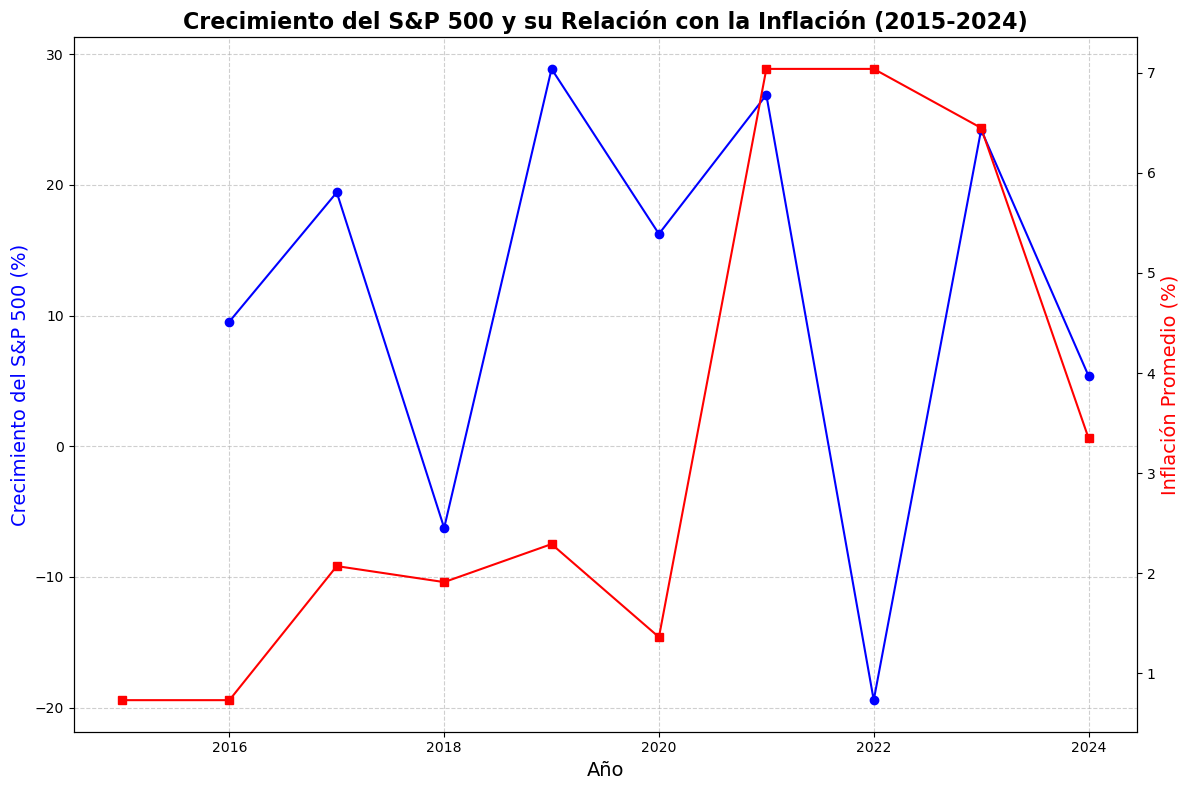

In [9]:
consulta4 = """
WITH yearly_data AS (
    SELECT 
        year(d.date) AS year,
        MAX(a.price_sp500) AS price_sp500,
        AVG(e.inflation) AS avg_inflation
    FROM 
        assets a
    JOIN 
        economic_factors e ON a.id_date = e.id_date
    JOIN 
        dates d ON a.id_date = d.id_date
    WHERE 
        d.date IN (SELECT MAX(d2.date) FROM dates d2 GROUP BY year(d2.date))
    GROUP BY 
        year(d.date)
)
SELECT 
    year,
    price_sp500,
    ROUND((price_sp500 - LAG(price_sp500) OVER (ORDER BY year)) / LAG(price_sp500) OVER (ORDER BY year) * 100, 2) AS sp500_growth,
    avg_inflation
FROM 
    yearly_data
ORDER BY 
    year;
"""
df4 = fn.execute_query(engine, consulta4)
fn.plot_sp500_inflation(df4)

In [10]:
df4

,year,price_sp500,sp500_growth,avg_inflation
0,2015,2044.0,NaN,0.73
1,2016,2239.0,9.54,0.73
2,2017,2674.0,19.43,2.07
3,2018,2507.0,-6.25,1.91
4,2019,3231.0,28.88,2.29
5,2020,3756.0,16.25,1.36
6,2021,4766.0,26.89,7.04
7,2022,3840.0,-19.43,7.04
8,2023,4770.0,24.22,6.45
9,2024,5027.0,5.39,3.35


- Consulta 5: Promedio y volatilidad de Bitcoin en condiciones de alta volatilidad e inflación

In [11]:
consulta5 = """
SELECT
    AVG(a.price_bitcoin) AS avg_bitcoin_price,
    STD(a.price_bitcoin) AS volatility_bitcoin,
    AVG(e.vix) AS avg_vix,
    AVG(e.inflation) AS avg_inflation
FROM
    assets a
JOIN
    economic_factors e ON a.id_date = e.id_date
WHERE
    e.vix > 30 AND e.inflation > 3;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df5 = pd.read_sql(consulta5, con=engine)

# Mostrar el DataFrame resultante
df5

,avg_bitcoin_price,volatility_bitcoin,avg_vix,avg_inflation
0,29918.191489,9361.21928,31.940213,7.04
